In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [110]:
# Get absolute file paths for all files in current directory
import os
files = []
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))

In [111]:
# Select correct csv files, import the data
# Training csv has 'train' in the filename
train_filename = list([x for x in files if "train" in x])[0]
# Testing csv has 'test' in the filename
test_filename = list([x for x in files if "test" in x])[0]
train = pd.read_csv(train_filename)
test = pd.read_csv(test_filename)

In [112]:
# Inspect columns, data formats, see what might be useful
print(train.head())
# We wouldn't expect name, ticket number to be useful for prediction
# The precise cabin number would not be useful for prediction
# but maybe whether or not the passenger had a cabin?

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [113]:
# A function that fills NaNs in column with a randomly chosen number
def column_fill_nan_random(dataframe, column_name):
    filler = np.random.randint(-10000, 10000)
    # Choose a new number so long as the chosen number already exists in the column
    while filler in dataframe[column_name].unique():
        filler = np.random.randint(-10000, 10000)
    dataframe[column_name] = dataframe[column_name].fillna(filler)
    return dataframe

In [114]:
# Conversion of text features to numerical features
def column_text_to_numerical_feature(dataframe, column_name):
    # Clear NaNs - here we don't care about the
    # precise value of the NaNs that we're replacing
    # we just want them to have the same numerical value
    # so that that next step will work
    dataframe = column_fill_nan_random(dataframe, column_name)
    # Find all unique values in the column
    unique_values = dataframe[column_name].unique()
    # For each value in the column, replace it by
    # the index of the value in the list of unique values
    # Thus all quantities in the column are replaced
    # by integers, such that two rows with the
    # same value will now have the same integer value
    dataframe[column_name] = dataframe[column_name].map(lambda s: list(unique_values).index(s))
    return dataframe
 
    
# Convert sex and embarkation point to integer labels
# Required for some machine learning algorithms
def text_to_numerical_features(dataframe):
    dataframe = column_text_to_numerical_feature(dataframe, "Sex")
    dataframe = column_text_to_numerical_feature(dataframe, "Embarked")
    return dataframe
    

# Do feature -> integer conversion on both training & testing data
train = text_to_numerical_features(train)
test = text_to_numerical_features(test)


In [115]:
# This function replaces NaNs in a particular column in
# a dataframe with the mean value of the !NaN rows
def column_replace_nans_with_mean(dataframe, column_name):
    dataframe[column_name] = dataframe[column_name].fillna(
        dataframe[column_name].mean()
    )
    return dataframe


# These columns in our dataframe will
# have their NaN values replaced by means
mean_replace_nan_columns = [
    "Age",
    "Fare"
]
for column_name in mean_replace_nan_columns:
    train = column_replace_nans_with_mean(train, column_name)
    test = column_replace_nans_with_mean(test, column_name)

In [116]:
# Select features to use in model
feature_names = [
    "Age",
    "Pclass",
    "SibSp",
    "Parch",
    "Fare",
    "Embarked"
]
train_on = train[feature_names]
test_on = test[feature_names]
# Also get labels
train_labels = train["Survived"]

In [117]:
# First try a logistic regression approach
# Requires scaled features
scaler = StandardScaler()
scaler.fit(train_on)
train_on_scaled = scaler.transform(train_on)
test_on_scaled = scaler.transform(test_on)

In [127]:
model = LogisticRegression()
model.fit(train_on_scaled, train_labels)
score = model.score(train_on_scaled, train_labels)
print("Logistic regression approach, training accuracy {:.3f}".format(score))

Logistic regression approach, training accuracy 0.719


/home/scott/.anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


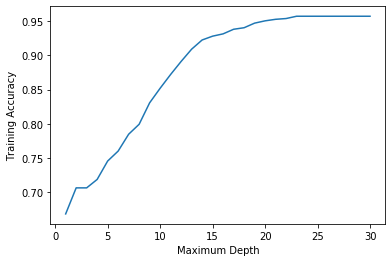

Best training accuracy 0.957 at maximum depth 25


In [129]:
# Try with a single decision tree
maximum_depths = range(1, 31)
scores = []
for maximum_depth in maximum_depths:
    classifier = DecisionTreeClassifier(
        max_depth=maximum_depth
    )
    classifier.fit(train_on, train_labels)
    scores.append(
        classifier.score(train_on, train_labels)
    )
plt.plot(maximum_depths, scores)
plt.xlabel("Maximum Depth")
plt.ylabel("Training Accuracy")
plt.show()
print(
    "Best training accuracy {:.3f}".format(scores[24]), 
    "at maximum depth", 
    maximum_depths[24]
)